# Selección de parámetros

In [1]:
from copy import deepcopy
import os
import re
from typing import Any

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from config import DATA_PATH, MODELS_PATH, VISUALIZATIONS_PATH

## Carga de datos y vectorizadores

In [8]:
data = pd.read_csv(
    os.path.join(DATA_PATH, "session_speech.csv"),
    converters={"speech_lemma_pos": eval}
)

INDEX = os.path.join(MODELS_PATH, "index")
X_train_index = (
    pd
    .read_csv(os.path.join(INDEX, f"X_train_index.csv"), header=None, index_col=0)
    .index
)
X_test_index = (
    pd
    .read_csv(os.path.join(INDEX, f"X_test_index.csv"), header=None, index_col=0)
    .index
)

le = joblib.load(os.path.join(MODELS_PATH, "labelencoder.pkl"))

VECTORIZERS = os.path.join(MODELS_PATH, "vectorizers")
proportions_vectorizer = joblib.load(os.path.join(VECTORIZERS, "proporciones_vectorizer.pkl"))

In [10]:
data = (
    data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
    .reset_index(drop=True)
    .assign(
        speech_lemma_pos=lambda x: x.speech_lemma_pos.apply(
            lambda z: " ".join(["_".join(i) for i in z])
        )
    )
)

In [12]:
data.head(2)

,name,vote,senator,province,party,party_family,speaker,speech,speech_preprocessed,speech_lemmas,speech_pos,speech_lemma_pos,speech_preprocessed_count,speech_preprocessed_count_unique,speech_lemmas_count,speech_lemmas_count_unique,speech_pos_count,speech_pos_count_unique,speech_lemma_pos_count_unique
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Almirón,"Hace dos años, tuvimos una sesión histórica cu...",hace dos años tuvimos una sesión histórica cua...,hacer año tener una sesión histórica cuando de...,VERB NOUN VERB DET NOUN ADJ SCONJ VERB ADP ADJ...,hacer_VERB año_NOUN tener_VERB una_DET sesión_...,1723,602,1684,459,1684,10,462
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN,Juntos por el cambio,Basualdo,"Gracias, señor presidente. Hoy es un día en el...",gracias señor presidente hoy es un día en el q...,gracia señor presidente hoy ser un día en el q...,NOUN NOUN NOUN ADV VERB DET NOUN ADP DET SCONJ...,gracia_NOUN señor_NOUN presidente_NOUN hoy_ADV...,411,187,405,146,405,10,147


## Vectorización de datos

In [13]:
TRAINSET_FOLDER = os.path.join(MODELS_PATH, "trainsets")
os.makedirs(TRAINSET_FOLDER, exist_ok=True)

TESTSET_FOLDER = os.path.join(MODELS_PATH, "testsets")
os.makedirs(TESTSET_FOLDER, exist_ok=True)

In [14]:
def build_features(
    df: pd.DataFrame, converters: dict[str, CountVectorizer], test: bool = True
):
    features, features_names = list(), list()
    for column, vectorizer in converters.items():
        if test:
            X = vectorizer.transform(df[column])
        else:
            X = vectorizer.fit_transform(df[column])
        print(f"{X.shape[1]} features added")
        features.append(X)
        features_names.extend(list(vectorizer.get_feature_names_out()))
    features_array = np.concatenate(list(map(lambda x: x.toarray(), features)), axis=1)
    features_df = pd.DataFrame(features_array, columns=features_names)
    return features_df

In [15]:
X_proportions = build_features(
    data,
    converters={"speech_lemma_pos": proportions_vectorizer}
)

X_train_proportions, X_test_proportions = (
    X_proportions.iloc[X_train_index], X_proportions.iloc[X_test_index]
)

X_train_proportions.to_csv(
    os.path.join(TRAINSET_FOLDER, "X_train_proporciones.csv"), index=False
)
X_test_proportions.to_csv(
    os.path.join(TESTSET_FOLDER, "X_test_proporciones.csv"), index=False
)

print(X_train_proportions.shape)
print(X_test_proportions.shape)

500 features added
(159, 500)
(40, 500)


In [16]:
y = le.transform(data["vote"])
y = pd.Series(y)

y_train, y_test = y.iloc[X_train_index], y.iloc[X_test_index]

y_train.to_csv(
    os.path.join(TRAINSET_FOLDER, "y_train.csv"),
    index=False, header=False
)
y_test.to_csv(
    os.path.join(TESTSET_FOLDER, "y_test.csv"),
    index=False, header=False
)

print(y_train.shape)
print(y_test.shape)

(159,)
(40,)


## Búsqueda exhaustiva

In [17]:
# about generated folds and random state
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

def fit_grid_search(
    clf: BaseEstimator, clf_parameters: dict[str, Any],
    X:pd.DataFrame, y:pd.Series,
    out_file: str = None
):
    gs = GridSearchCV(
        clf,
        clf_parameters,
        scoring='f1',
        cv=5,
        return_train_score=True,
        n_jobs=-1
    )
    gs.fit(X, y)
    if out_file:
        FOLDER = os.path.join(MODELS_PATH, "gridsearch")
        os.makedirs(FOLDER, exist_ok=True)
        FILE = os.path.join(FOLDER, out_file)
        joblib.dump(gs, FILE, compress=True)
    return gs

In [18]:
def build_results(cv_results: dict[str, np.ndarray]) -> pd.DataFrame:
    df_cv_results = pd.DataFrame(cv_results)
    param_cols = df_cv_results.filter(regex="param_").columns.tolist()
    df_cv_results.drop(columns=param_cols, inplace=True)
    df_cv_results["params"] = (
        df_cv_results
        .params
        .apply(lambda x: "-".join([f"{k}={v}" for k, v in x.items()]))
    )
    df_cv_results.set_index("params", inplace=True)
    df_cv_results.sort_values(by="rank_test_score", inplace=True)
    df_cv_results = df_cv_results[df_cv_results.columns.sort_values().tolist()]
    return df_cv_results

In [19]:
def build_results2plot(results: pd.DataFrame) -> pd.DataFrame:
    split_cols = results.filter(regex=r"(split\d+\_test)").columns.to_list()
    return (
        pd.concat([
            results.nlargest(3, "mean_test_score"),
            results.nsmallest(3, "std_test_score")
        ])
        .drop_duplicates(keep="first")
        .reset_index()
        .melt(
            id_vars = ["params"],
            value_vars = split_cols,
            var_name = "measure"
        )
        .merge(
            results[["mean_test_score", "std_test_score"]],
            left_on = "params", right_index = True
        )
        .reset_index(drop=True)
    )

In [20]:
def plot_results(
    results: pd.DataFrame,
    clf: str,
    file_name: str = None,
    ncol: int = None,
    bbox_y: int = None
    ) -> None:
    results2plot = build_results2plot(results)
    fig, axs = plt.subplots(1, 2, figsize=(9,3))
    for params, df in results2plot.groupby("params"):
        _df = df[["params", "mean_test_score", "std_test_score"]].drop_duplicates(keep="first")
        axs[0].errorbar(
            x=_df.mean_test_score,
            xerr=_df.std_test_score,
            y=_df.params,
            fmt="o",
            label=params
        )
        axs[1].errorbar(
            x=df.measure,
            y=df.value,
            label=params
        )
    axs[0].set_yticks([])
    axs[0].set_xlabel("")
    axs[0].set_title("Promedio y desvío")
    axs[1].set_xticklabels([
        "split {n}".format(n=re.search(r'\d+', label.get_text()).group())
        for label in axs[1].get_xticklabels()
    ])
    axs[1].set_xlabel("")
    axs[1].set_title("Por split")
    title = fig.suptitle(f"{clf}:\nF1-score en test en validación cruzada", y=1.13)
    if ncol is None:
        n_models = results2plot.params.nunique()
        ncol = min(n_models, 4)
    bbox_y = bbox_y if bbox_y else -0.3
    lgd = plt.legend(loc="lower center", bbox_to_anchor=(-0.1, bbox_y), ncol=ncol)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[lgd,title], bbox_inches='tight'
        )

### Naive Bayer Multinomial

In [21]:
nb_gridsearch = dict()

for df, name in zip([X_train_proportions], ["proporciones"]):
    gs = fit_grid_search(
        clf=MultinomialNB(),
        clf_parameters={"alpha": [0.01, 0.1, 1.0]},
        X=df,
        y=y_train,
        out_file=f"nb_{name}.pkl"
    )
    nb_gridsearch[name] = {"trainset": df, "grid_search": gs}

In [22]:
for key in nb_gridsearch.keys():
    print(f"--- {key.upper()} ---")
    print(nb_gridsearch[key]["grid_search"])

--- PROPORCIONES ---
GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0]}, return_train_score=True,
             scoring='f1')


In [23]:
nb_gridsearch_results = dict()

for key, value in nb_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    nb_gridsearch_results[key] = results
    print(f"--- {key.upper()} ---")
    print(results.T.head())

--- PROPORCIONES ---
params            alpha=0.01  alpha=0.1  alpha=1.0
mean_fit_time       0.023212   0.024428   0.020277
mean_score_time     0.023232   0.025566   0.018160
mean_test_score     0.750254   0.742678   0.722548
mean_train_score    0.765008   0.765008   0.762824
rank_test_score     1.000000   2.000000   3.000000


/tmp/ipykernel_57910/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([


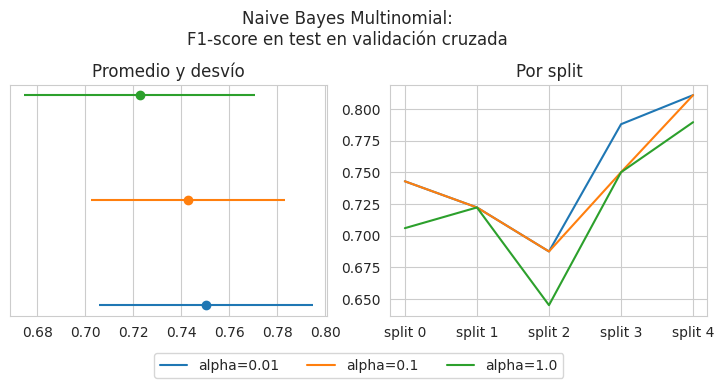

In [25]:
for key, value in nb_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    plot_results(
        results,
        f"Naive Bayes Multinomial",
        file_name=f"nb_f1score_split_comparison_{key}"
    )

### Regresión Logística

In [26]:
lr_gridsearch = dict()

for df, name in zip([X_train_proportions], ["proporciones"]):
    gs = fit_grid_search(
        clf=LogisticRegression(
            multi_class="ovr", solver="liblinear", random_state=6300
        ),
        clf_parameters={"penalty": ["l1", "l2"], "C": [0.1, 0.5, 1]},
        X=df,
        y=y_train,
        out_file=f"lr_{name}.pkl"
    )
    lr_gridsearch[name] = {"trainset": df, "grid_search": gs}

In [27]:
for key in lr_gridsearch.keys():
    print(f"--- {key.upper()} ---")
    print(lr_gridsearch[key]["grid_search"])

--- PROPORCIONES ---
GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=6300,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')


In [28]:
lr_gridsearch_results = dict()

for key, value in lr_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    lr_gridsearch_results[key] = results
    print(f"--- {key.upper()} ---")
    print(results.T.head())

--- PROPORCIONES ---
params            C=0.1-penalty=l2  C=1-penalty=l2  C=0.5-penalty=l2  \
mean_fit_time             0.025529        0.025271          0.023247   
mean_score_time           0.022331        0.017400          0.022375   
mean_test_score           0.712576        0.695948          0.677813   
mean_train_score          0.812080        0.842026          0.835916   
rank_test_score           1.000000        2.000000          3.000000   

params            C=0.5-penalty=l1  C=1-penalty=l1  C=0.1-penalty=l1  
mean_fit_time             0.024108        0.030019          0.021942  
mean_score_time           0.020913        0.024533          0.024252  
mean_test_score           0.577833        0.564772          0.473538  
mean_train_score          0.706900        0.747235          0.493941  
rank_test_score           4.000000        5.000000          6.000000  


/tmp/ipykernel_57910/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([


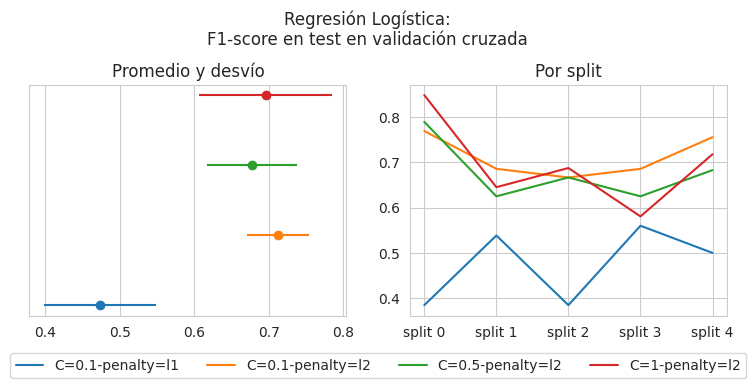

In [29]:
for key, value in lr_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    plot_results(
        results,
        f"Regresión Logística",
        file_name=f"lr_f1score_split_comparison_{key}"
    )

### Máquinas de Soporte Vectorial

In [30]:
svm_gridsearch = dict()

for df, name in zip(
    [X_train_proportions], ["proporciones"]
    ):
    gs = fit_grid_search(
        clf=SVC(random_state=6300, probability=True),
        clf_parameters={
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "C": [0.1, 0.5, 1],
            "decision_function_shape": ["ovo", "ovr"]
        },
        X=df,
        y=y_train,
        out_file=f"svm_{name}.pkl"
    )
    svm_gridsearch[name] = {"trainset": df, "grid_search": gs}

In [31]:
for key in svm_gridsearch.keys():
    print(f"--- {key.upper()} ---")
    print(lr_gridsearch[key]["grid_search"])

--- PROPORCIONES ---
GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=6300,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')


In [32]:
svm_gridsearch_results = dict()

for key, value in svm_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    svm_gridsearch_results[key] = results
    print(f"--- {key.upper()} ---")
    print(results.T.head())

--- PROPORCIONES ---
params            C=0.1-decision_function_shape=ovo-kernel=rbf  \
mean_fit_time                                         0.100829   
mean_score_time                                       0.034967   
mean_test_score                                       0.717667   
mean_train_score                                      0.717737   
rank_test_score                                       1.000000   

params            C=0.1-decision_function_shape=ovo-kernel=sigmoid  \
mean_fit_time                                             0.068293   
mean_score_time                                           0.029225   
mean_test_score                                           0.717667   
mean_train_score                                          0.717737   
rank_test_score                                           1.000000   

params            C=0.1-decision_function_shape=ovr-kernel=rbf  \
mean_fit_time                                         0.085675   
mean_score_time              

/tmp/ipykernel_57910/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([


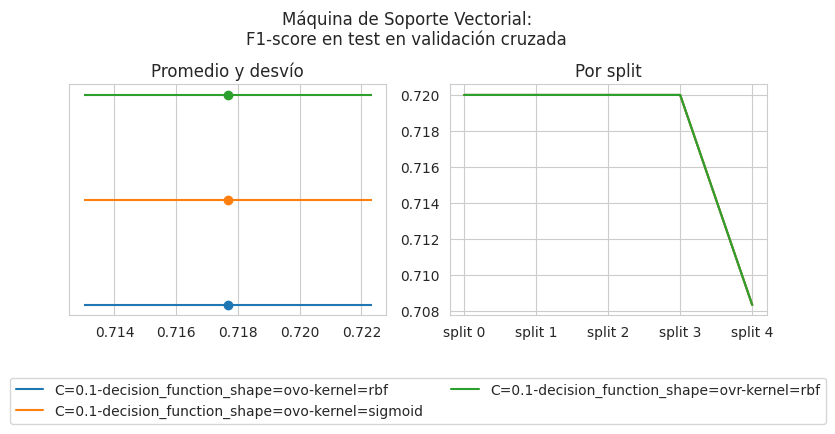

In [33]:
for key, value in svm_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    f = plot_results(
        results,
        f"Máquina de Soporte Vectorial",
        ncol=2,
        bbox_y=-.5,
        file_name=f"svm_f1score_split_comparison_{key}"
    )

## Selección de mejores estimadores

In [34]:
def print_best_estimator_info(gs_estimators: GridSearchCV) -> None:
    best_params = "\n\t- ".join(
        [f"{k}: {v}" for k, v in gs_estimators.best_params_.items()]
    )
    print(f"""
    ** Mejor conjunto de parámetros:\n\t- {best_params}
    ** Mejor score promedio en validación cruzada: {gs_estimators.best_score_}
    """)

### Multinomial Naive Bayes

In [35]:
for key, value in nb_gridsearch.items():
    print(f"--- {key.upper()} ---")
    print_best_estimator_info(value["grid_search"])

--- PROPORCIONES ---

    ** Mejor conjunto de parámetros:
	- alpha: 0.01
    ** Mejor score promedio en validación cruzada: 0.7502537927537928
    


### Logistic Regression

In [36]:
for key, value in lr_gridsearch.items():
    print(f"--- {key.upper()} ---")
    print_best_estimator_info(value["grid_search"])

--- PROPORCIONES ---

    ** Mejor conjunto de parámetros:
	- C: 0.1
	- penalty: l2
    ** Mejor score promedio en validación cruzada: 0.7125763125763125
    


### Máquinas de Soporte Vectorial

In [37]:
for key, value in svm_gridsearch.items():
    print(f"--- {key.upper()} ---")
    print_best_estimator_info(value["grid_search"])

--- PROPORCIONES ---

    ** Mejor conjunto de parámetros:
	- C: 0.1
	- decision_function_shape: ovo
	- kernel: rbf
    ** Mejor score promedio en validación cruzada: 0.7176666666666666
    


## Importancia de rasgos

In [38]:
FOLDER = os.path.join(MODELS_PATH, "refit")
os.makedirs(FOLDER, exist_ok=True)

### Naive Bayes Multinomial

In [39]:
def plot_nb_weights(df: pd.DataFrame, title:str, file_name:str = None):
    fig, axs = plt.subplots(1,2, figsize=(12,3), sharey=True)
    sns.histplot(
        data = df.melt(id_vars=["word"], var_name="weight"),
        x="value",
        hue="weight",
        bins=30,
        ax=axs[0]
    )
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Observaciones")
    axs[0].set_title("Pesos por categoría")
    axs[0].get_legend().set_title("Pesos")
    sns.histplot(
        data = df.assign(diff=lambda x: x.pos-x.neg),
        x="diff",
        bins=30,
        ax=axs[1]
    )
    axs[1].set_title("Diferencia de pesos: $pos-neg$")
    title = fig.suptitle(title,  y=1.05)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title], bbox_inches='tight'
        )

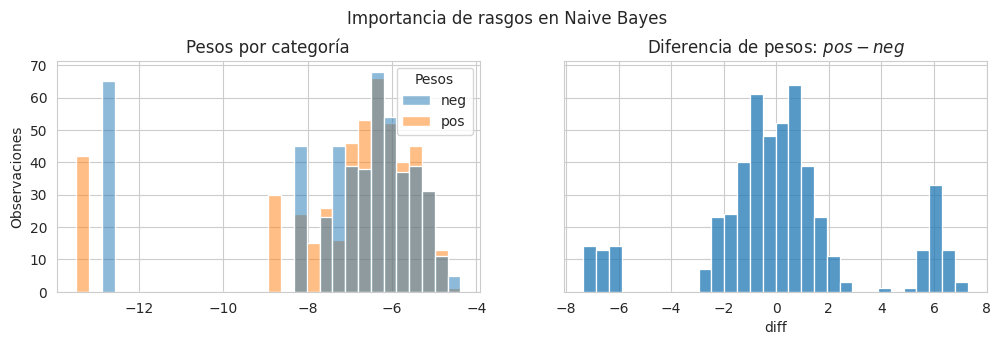

In [40]:
for key, value in nb_gridsearch.items():
    estimator, x_train = value["grid_search"].best_estimator_, value["trainset"]
    value["refit"] = estimator.fit(x_train, y_train)
    best_nb_weights = pd.DataFrame(
        {
            "word": x_train.columns.to_list(),
            "neg": estimator.feature_log_prob_[0],
            "pos": estimator.feature_log_prob_[1]
        }
    )
    value["refit_weights"] = best_nb_weights
    FILE = os.path.join(FOLDER, f"nb_{key}.pkl")
    joblib.dump(estimator, FILE, compress=True)
    plot_nb_weights(
        best_nb_weights,
        title=f"Importancia de rasgos en Naive Bayes",
        file_name=f"nb_best_feature_importance_{key}"
    )

### Regresión Logística

In [41]:
def plot_lr_weights(df: pd.DataFrame, title:str, file_name:str=None):
    df_copy = deepcopy(df)
    df_copy.loc[df_copy.coef >= 0, "weight"] = "pos"
    df_copy.loc[df_copy.coef < 0, "weight"] = "neg"
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(
        data = df_copy,
        x="coef",
        hue="weight",
        bins=30,
        ax=ax
    )
    ax.set_xlabel("")
    ax.set_ylabel("Observaciones")
    ax.get_legend().set_title("Pesos")
    fig.suptitle(title)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title]
        )

def plot_lr_weights_barplot(
        df: pd.DataFrame,
        title:str,
        n: int = 25,
        file_name:str=None
    ):
    fig, axs = plt.subplots(1, 2, figsize=(9,6))
    sns.barplot(
        df[df.coef<0].nsmallest(n, columns=["coef"], keep="all"),
        x = "coef", y = "word",
        ax=axs[0],
        palette="tab10",
        alpha=.6
    )
    axs[0].set_title("Coeficientes negativos")
    axs[0].set_ylabel("")
    axs[0].set_xlabel("Magnitudd")
    sns.barplot(
        df[df.coef>=0].nlargest(n, columns=["coef"], keep="all"),
        x = "coef", y = "word",
        ax=axs[1],
        palette="tab10",
        alpha=.6
    )
    axs[1].set_title("Coeficientes positivos")
    axs[1].yaxis.tick_right()
    axs[1].set_ylabel("")
    axs[1].set_xlabel("Magnitudd")
    fig.suptitle(title, fontsize=14)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title]
        )

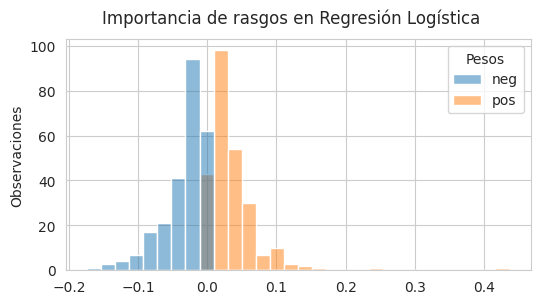

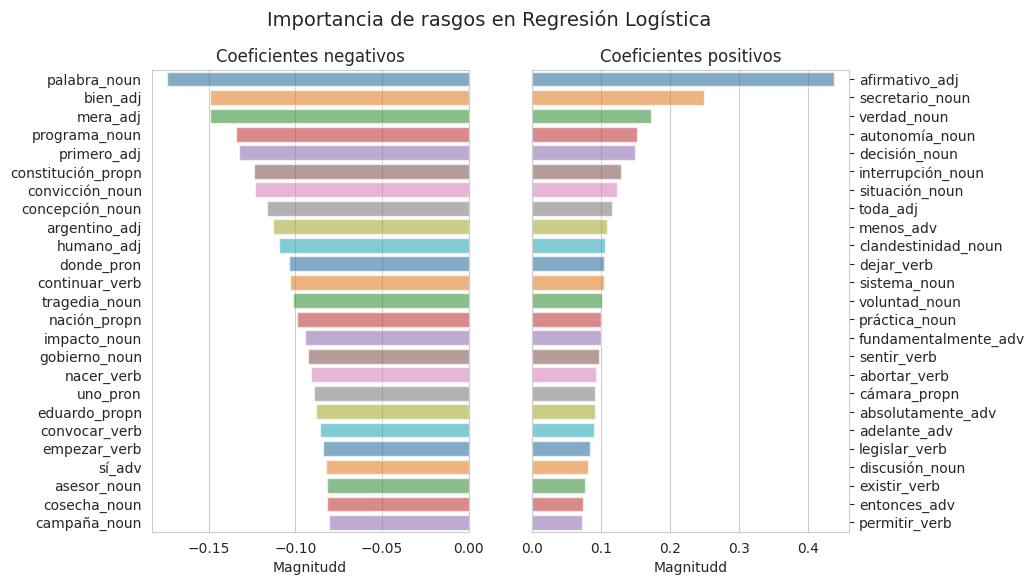

In [42]:
for key, value in lr_gridsearch.items():
    estimator, x_train = value["grid_search"].best_estimator_, value["trainset"]
    value["refit"] = estimator.fit(x_train, y_train)
    best_lr_weights = pd.DataFrame(
        {
            "word": x_train.columns.to_list(),
            "coef": estimator.coef_[0]
        }
    )
    value["refit_weights"] = best_lr_weights
    FILE = os.path.join(FOLDER, f"lr_{key}.pkl")
    joblib.dump(estimator, FILE, compress=True)
    plot_lr_weights(
        best_lr_weights,
        title=f"Importancia de rasgos en Regresión Logística",
        file_name=f"lr_best_feature_importance_{key}"
    )
    plot_lr_weights_barplot(
        best_lr_weights,
        title=f"Importancia de rasgos en Regresión Logística",
        file_name=f"lr_best_feature_importance_barplot_{key}"
    )

### Máquinas de Soporte Vectorial

In [46]:
for key, value in svm_gridsearch.items():
    estimator, x_train = value["grid_search"].best_estimator_, value["trainset"]
    value["refit"] = estimator.fit(x_train, y_train)
    FILE = os.path.join(FOLDER, f"svm_{key}.pkl")
    joblib.dump(estimator, FILE, compress=True)
    if estimator.kernel == "linear":
        best_svm_weights = pd.DataFrame(
            {
                "word": x_train.columns.to_list(),
                "coef": estimator.coef_[0],
            }
        )
        value["refit_weights"] = best_nb_weights
        plot_lr_weights(
            best_svm_weights,
            title=f"Importancia de rasgos en SVM",
            file_name=f"svm_best_feature_importance_{key}"
        )
        plot_lr_weights_barplot(
            best_svm_weights,
            title=f"Importancia de rasgos en SVM",
            file_name=f"svm_best_feature_importance_barplot_{key}"
        )

In [49]:
for key, value in svm_gridsearch.items():
    estimator, x_train = value["grid_search"].best_estimator_, value["trainset"]
    if estimator.kernel == "rbf":
        print(key)

proporciones


In [53]:
estimator = svm_gridsearch["proporciones"]["grid_search"].best_estimator_